In [13]:
%matplotlib inline
from sklearn.cross_decomposition import CCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product


class LAM_Linear(nn.Module):
    def __init__(self, d_o, d_z, d_a, learn_A=True):
        super(LAM_Linear, self).__init__()
        self.learn_A = learn_A
        if self.learn_A:
            self.A = nn.Linear(d_o, d_o, bias=False)
        # self.B = nn.Linear(d_z, d_o, bias=False)
        self.C = nn.Linear(d_o, d_z, bias=False)
        self.D = nn.Linear(d_o, d_z, bias=False)
        self.E = nn.Linear(d_z, d_o, bias=False)
        self.action_pred = nn.Linear(d_z, d_a)

    def forward(self, o, o_next):
        z = self.C(o) + self.D(o_next)
        if self.learn_A:
            obs_pred = self.A(o) + self.E(z)
        else:
            obs_pred = o + self.E(z)
        action = self.action_pred(z)
        return obs_pred, action, z

In [15]:
def generate_true_U(action_embeddings):
    N = 10000

    actions = np.random.randint(num_actions, size=(N,))
    A = np.zeros((num_actions, N))
    A[actions, np.arange(N)] = 1

    Q = action_embeddings @ A 

    U, S, V = np.linalg.svd(Q)
    return U

def principal_angles(X, Y):
    # Orthonormalize the basis vectors using QR decomposition
    Q1, _ = np.linalg.qr(X)
    Q2, _ = np.linalg.qr(Y)
    
    # Compute the product of transposed Q1 and Q2
    M = Q1.T @ Q2
    
    # Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(M)

    # Clip singular values to avoid numerical errors (arccos domain [-1, 1])
    S_clipped = np.clip(S, -1.0, 1.0)

    # Compute principal angles in radians (sorted in ascending order)
    angles_rad = np.arccos(S_clipped)
    
    return angles_rad

def tensorboard_smooth(data, alpha=0.6):
    """Apply exponential moving average smoothing to 1D data.
    
    Args:
        data: Input array (np.ndarray or pd.Series)
        alpha: Smoothing factor (0 < alpha ≤ 1), default 0.6 (TensorBoard's default)
    
    Returns:
        Smoothed array with same dtype as input
    """
    # Convert Series to numpy array while preserving index
    if isinstance(data, pd.Series):
        original_index = data.index
        data = data.values
    else:
        original_index = None

    smoothed = np.zeros_like(data)
    smoothed[0] = data[0]
    
    for i in range(1, len(data)):
        smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i-1]

    # Reconstruct original data type
    return pd.Series(smoothed, index=original_index) if original_index is not None else smoothed

def calculate_cca(X, Y):

    cca = CCA(n_components=1)
    cca.fit(X, Y) 

    x_c, y_c = cca.transform(X, Y)
    corr = np.corrcoef(x_c.T, y_c.T)[0, 1]

    return corr

def calculate_cca_last(lam, policy, discrete_actions, dim, num_actions, action_embeddings, policy_mat, N=10000):

    O = np.random.rand(dim, N)

    if policy == 'uniform':
        if discrete_actions:
            actions = np.random.randint(num_actions, size=(N,))
            A = np.zeros((num_actions, N))
            A[actions, np.arange(N)] = 1
        else:
            A = np.random.randn(num_actions, N)
    elif policy == 'deterministic':
        if discrete_actions:
            out = policy_mat @ O
            actions = (out[0] > 0) * 4 + (out[1] > 0) * 2 + (out[2] > 0) * 1
            A = np.zeros((num_actions, N))
            A[actions, np.arange(N)] = 1
        else:
            A = policy_mat @ O 
    elif policy == 'stochastic':
        if discrete_actions:
            out = policy_mat @ O
            actions = (out[0] > 0) * 4 + (out[1] > 0) * 2 + (np.random.randn(N) > 0) * 1
            A = np.zeros((num_actions, N))
            A[actions, np.arange(N)] = 1
        else:
            stochastic = np.random.randn(num_actions, N)
            stochastic[1:] = 0
            A = policy_mat @ O + stochastic

    act_targ = torch.tensor(A.T, dtype=torch.float32)
        
    Q = action_embeddings @ A 
    Op = O + Q

    tensor_O = torch.tensor(O.T, dtype=torch.float32)
    tensor_Op = torch.tensor(Op.T, dtype=torch.float32)

    _, _, z = lam(tensor_O, tensor_Op)

    X = z.detach().numpy()
    Y = act_targ.detach().numpy()
    cca = calculate_cca(X, Y)

    return cca



In [18]:
N = 128
num_actions = 8
dim = 128
dim_z = 8

action_embeddings = np.random.randn(dim, num_actions)
action_embeddings, _ = np.linalg.qr(action_embeddings) 

main_lam = LAM_Linear(dim, dim_z, num_actions, learn_A=True)

record = []

for discrete_actions, policy, learn_A, pred_actions in product([True, False], ['uniform', 'deterministic', 'stochastic'], [True, False], [True, False]):

    lam = LAM_Linear(dim, dim_z, num_actions, learn_A=learn_A)
    lam.load_state_dict(main_lam.state_dict(), strict=False)
    opt = optim.Adam(lam.parameters())

    if discrete_actions:
        policy_mat = np.random.randn(3, dim)
    else:
        policy_mat = np.random.randn(num_actions, dim)

    for i_batch in range(5000):

        O = np.random.rand(dim, N)

        if policy == 'uniform':
            if discrete_actions:
                actions = np.random.randint(num_actions, size=(N,))
                A = np.zeros((num_actions, N))
                A[actions, np.arange(N)] = 1
            else:
                A = np.random.randn(num_actions, N)
        elif policy == 'deterministic':
            if discrete_actions:
                out = policy_mat @ O
                actions = (out[0] > 0) * 4 + (out[1] > 0) * 2 + (out[2] > 0) * 1
                A = np.zeros((num_actions, N))
                A[actions, np.arange(N)] = 1
            else:
                A = policy_mat @ O 
        elif policy == 'stochastic':
            if discrete_actions:
                out = policy_mat @ O
                actions = (out[0] > 0) * 4 + (out[1] > 0) * 2 + (np.random.randn(N) > 0) * 1
                A = np.zeros((num_actions, N))
                A[actions, np.arange(N)] = 1
            else:
                stochastic = np.random.randn(num_actions, N)
                stochastic[1:] = 0
                A = policy_mat @ O + stochastic

        act_targ = torch.tensor(A.T, dtype=torch.float32)
            
        Q = action_embeddings @ A 
        Op = O + Q

        tensor_O = torch.tensor(O.T, dtype=torch.float32)
        tensor_Op = torch.tensor(Op.T, dtype=torch.float32)

        obs_pred, act_pred, z = lam(tensor_O, tensor_Op)
        loss_obs = nn.MSELoss()(obs_pred, tensor_Op)

        X = z.detach().numpy()
        Y = act_targ.detach().numpy()
        cca = calculate_cca(X, Y)

        mask = (torch.rand(N) <= 0.1)
        loss_act = (((act_pred - act_targ) ** 2).mean(1) * mask).mean()

        if pred_actions:
            loss = loss_obs + loss_act
        else:
            loss = loss_obs
        opt.zero_grad()
        loss.backward()
        opt.step()

        angles = principal_angles(action_embeddings, lam.E.weight.detach().numpy())
        max_angle = np.max(angles)

        corr_values = pd.DataFrame(lam.E.weight.detach().numpy()).corr().abs().values
        mean_corr = corr_values[np.triu_indices_from(corr_values, k=1)].mean()

        record.append({
            'policy': policy,
            'discrete_A': discrete_actions,
            'learn_A': learn_A,
            'pred_A': pred_actions,
            'batch': i_batch,
            'loss_act': loss_act.item(),
            'loss_obs': loss_obs.item(),
            'loss': loss.item(),
            'angle': max_angle,
            'cca': cca,
            'decoder_corr': mean_corr,
        })

    last_cca = calculate_cca_last(lam, policy, discrete_actions, dim, num_actions, action_embeddings, policy_mat, N=10000)
    record[-1].update({'last_cca': last_cca})

record = pd.DataFrame(record)


/home/chuheng/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/chuheng/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/chuheng/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/chuheng/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/chuheng/anaconda3/envs/jupyter/lib/pyt

In [ ]:
def plot(iterator):
    dfs = {}
    for discrete_actions, policy, learn_A, pred_actions in iterator:
        d = record.loc[(record['policy'] == policy) & (record['learn_A'] == learn_A) & (record['discrete_A'] == discrete_actions) & (record['pred_A'] == pred_actions)]
        k1 = 'disc. ' if discrete_actions else 'cont. '
        k3 = ' learn A' if learn_A else ' fix A'
        k4 = ' label' if pred_actions else ''
        key = k1 + policy + k3 + k4
        dfs[key] = d

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    for key, d in dfs.items():
        plt.plot(d['batch'], tensorboard_smooth(d['loss'], alpha=0.1).clip(lower=1e-6), label=key)
    plt.legend()
    plt.ylim([0, 0.01])
    plt.xlim([0, 5000])
    # plt.yscale('log')
    plt.xlabel('Training Iteration')
    plt.title('Total Loss')

    plt.subplot(2, 3, 2)
    for key, d in dfs.items():
        plt.plot(d['batch'], tensorboard_smooth(d['angle'], alpha=0.1))
    plt.legend()
    plt.ylim([0, 1.6])
    plt.xlim([0, 5000])
    plt.xlabel('Training Iteration')
    plt.title('Principal Angle between Decoder and \n Ground Truth $X$ (RAD)')

    plt.subplot(2, 3, 3)
    for key, d in dfs.items():
        plt.plot(d['batch'], tensorboard_smooth(d['decoder_corr'], alpha=0.1))
    plt.legend()
    plt.ylim([0, 0.3])
    plt.xlim([0, 5000])
    plt.xlabel('Training Iteration')
    plt.title('decoder_corr')

    plt.subplot(2, 3, 4)
    for key, d in dfs.items():
        plt.plot(d['batch'], tensorboard_smooth(d['loss_obs'], alpha=0.1).clip(lower=1e-6))
    plt.legend()
    plt.ylim([0, 0.003])
    plt.xlim([0, 5000])
    # plt.yscale('log')
    plt.xlabel('Training Iteration')
    plt.title('Loss Obs')

    plt.subplot(2, 3, 5)
    for key, d in dfs.items():
        plt.plot(d['batch'], tensorboard_smooth(d['loss_act'], alpha=0.1))
    plt.legend()
    plt.ylim([0, 0.3])
    plt.xlim([0, 5000])
    plt.xlabel('Training Iteration')
    plt.title('Loss Act')

    plt.subplot(2, 3, 6)
    for key, d in dfs.items():
        plt.plot(d['batch'], tensorboard_smooth(d['cca'], alpha=0.1))
    plt.legend()
    plt.ylim([0, 1])
    plt.xlim([0, 5000])
    plt.xlabel('Training Iteration')
    plt.title('CCA')

# Discrete, no pred action

/tmp/ipykernel_910194/317850623.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:63: UserWarning: No artists with labels found to put in legend.  Note

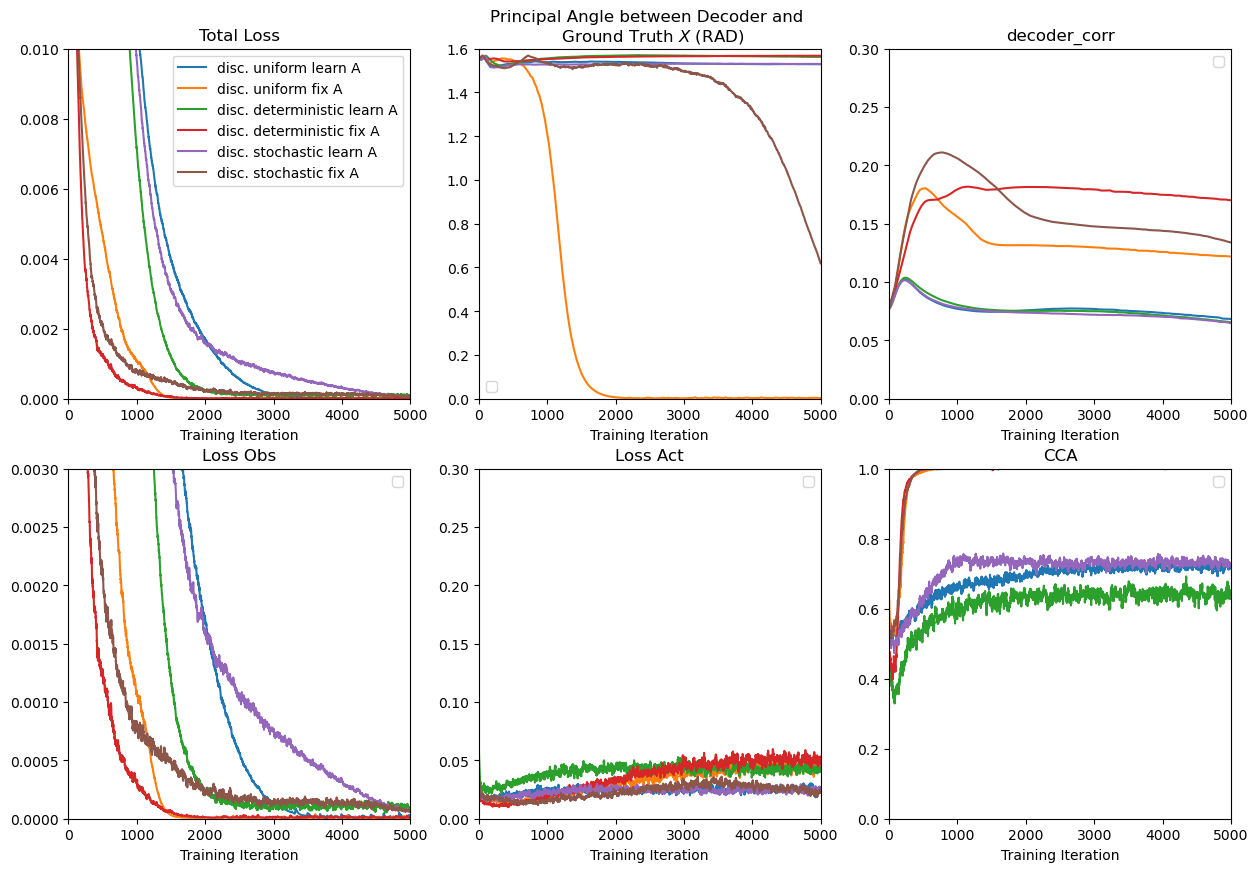

In [24]:
plot(product([True], ['uniform', 'deterministic', 'stochastic'], [True, False], [False]))

# Continuous

/tmp/ipykernel_910194/317850623.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:63: UserWarning: No artists with labels found to put in legend.  Note

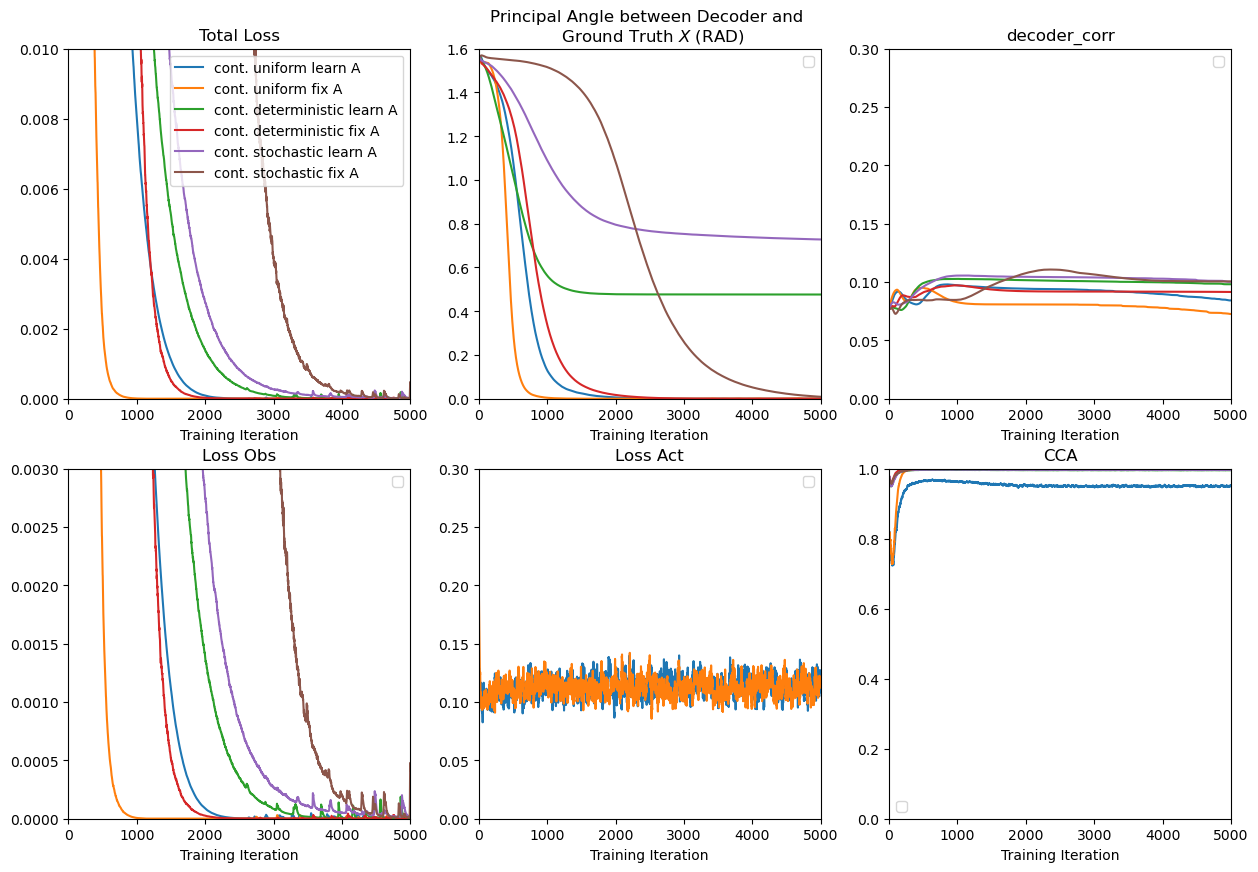

In [25]:
plot(product([False], ['uniform', 'deterministic', 'stochastic'], [True, False], [False]))

# Predict action + Discrete

/tmp/ipykernel_910194/317850623.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:63: UserWarning: No artists with labels found to put in legend.  Note

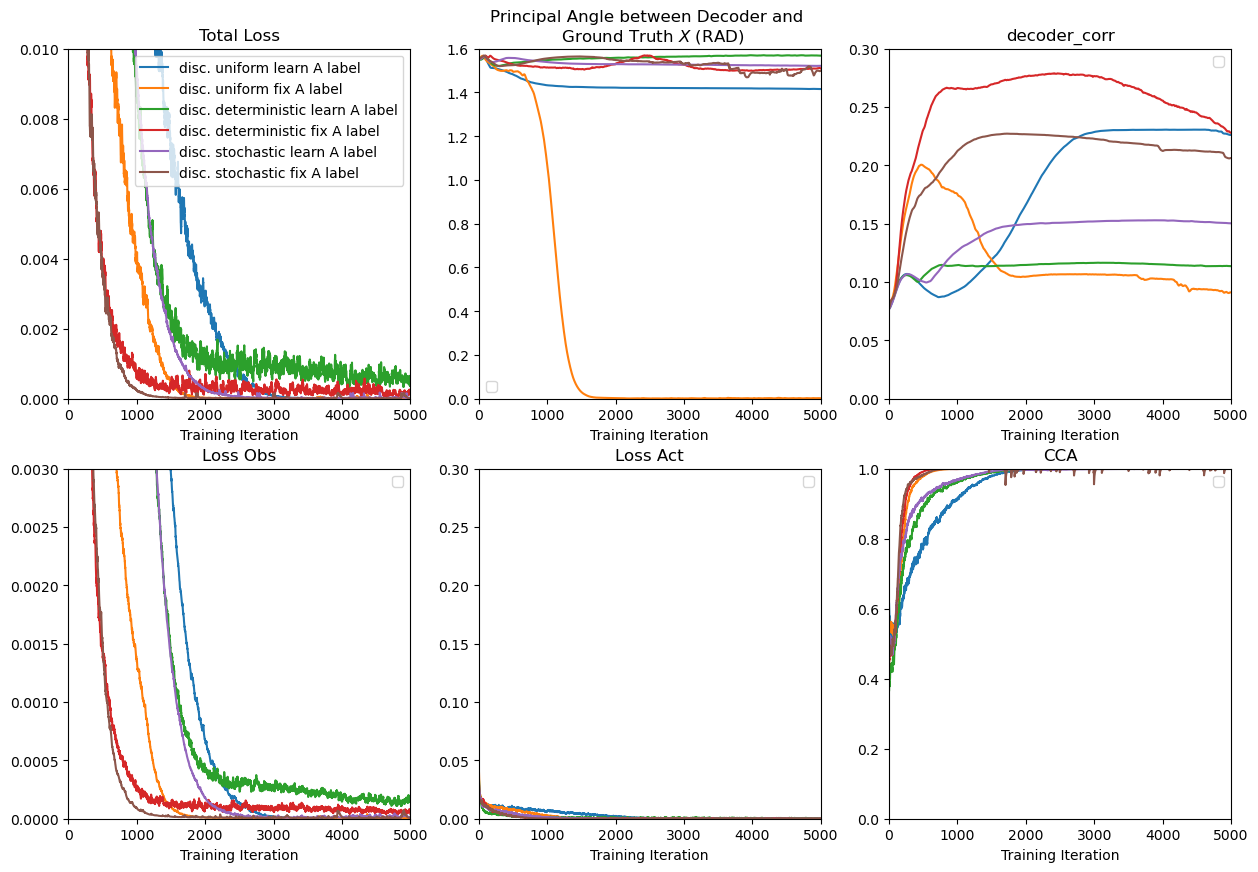

In [27]:
plot(product([True], ['uniform', 'deterministic', 'stochastic'], [True, False], [True]))

# Predict action + Continuous

/tmp/ipykernel_910194/317850623.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_910194/317850623.py:63: UserWarning: No artists with labels found to put in legend.  Note

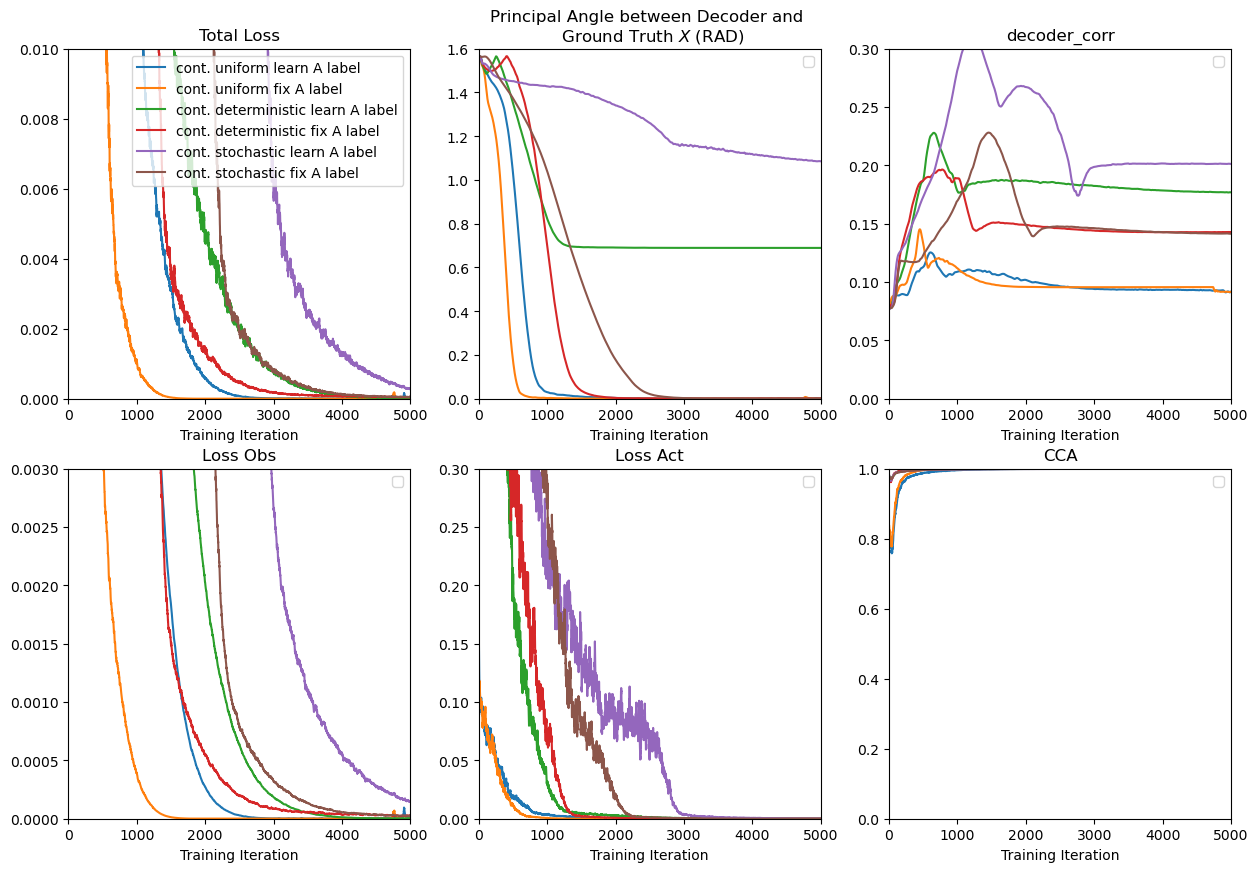

In [26]:
plot(product([False], ['uniform', 'deterministic', 'stochastic'], [True, False], [True]))